FFT calculation examples for future reference
- what are the units?
- converting to power or dBm

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import scipy.fftpack
from scipy.signal import blackman
from scipy.signal import tukey
import matplotlib.pyplot as plt

Create a test wave form, 2 sine wave

In [2]:
n = 500   # number of sample points
dt = .01  # data time step
t = np.linspace(0.0, n*dt, n)
y = np.sin(5.0 * 2.0*np.pi*t) + 0.5*np.sin(8.0 * 2.0*np.pi*t)
print('length of data set: {:d} samples'.format(n))
print('data time step: {:.3f} sec'.format(dt))
print('data capture interval: {:.1f} sec'.format(n*dt))
print('sample frequency: {:.1f} Hz'.format(1/dt))
print('Nyquist frequency: {:.1f} Hz'.format(1/dt/2))
print('peak value: {:.3f} volts'.format(y.max()))

length of data set: 500 samples
data time step: 0.010 sec
data capture interval: 5.0 sec
sample frequency: 100.0 Hz
Nyquist frequency: 50.0 Hz
peak value: 1.489 volts


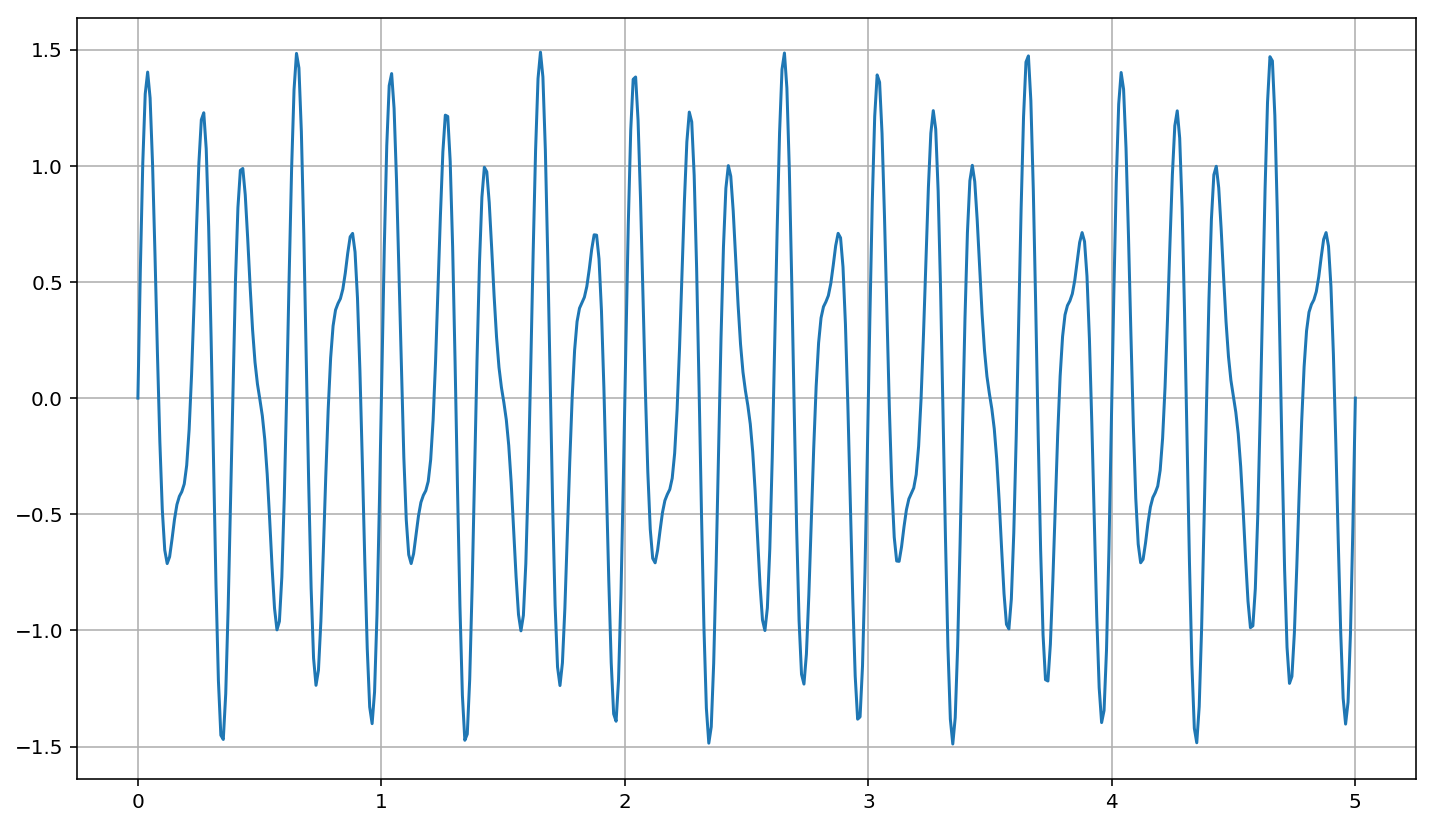

In [3]:
plt.plot(t, y)
plt.grid()
plt.show()

Use a window function

In [4]:
#w = tukey(n)
w = blackman(n)
yw = y*w

In [5]:
# plot the data
plt.plot(t,y)
plt.plot(t,yw)
plt.plot(t,w)
plt.xlabel('Time, sec')
plt.ylabel('Voltage, volts')
plt.legend(['Voltage', 'windowed data', 'window function'], loc='best')
plt.title('Title')
plt.show()

In [6]:
print('peak value: {:.3f} volts'.format(yw.max()))

peak value: 1.463 volts


The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

In [8]:
sample_freq = scipy.fftpack.fftfreq(n, d=dt)
fft_y = scipy.fftpack.fft(yw)

Plot the data on a semilog scale.

In [37]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude = sample_freq[pidxs], np.abs(fft_y[pidxs])
amplitude *= dt
plt.semilogy(freqs,amplitude)
plt.ylabel('amplitude')
plt.xlabel('frequency, Hz')
plt.title('FFT test plot')
plt.grid()
plt.show()

This seems to return a number that is near the correct value.

In [28]:
amplitude.max()

104.65819713831527

In [40]:
amplitude[39]

0.52227908831444014

In [24]:
50/250

0.2

In [39]:
Hz = 8
int(Hz/((1/dt/2)/(n/2))-1)

39

Need to scalse the data

Is it customary to correct for the gain of a window?

Consider how the Hanning window is defined:

0.5 - 0.5 * cos(n*2*Pi/(N-1))
By this definition, it has a gain of 0.5, which is simply the average value of the coefficients. By contrast, Flattop windows, as defined, have unity gain, presumably by design.

It would seem appropriate to scale the Hanning window by a factor of 2, but I have never seen this discussed anywhere. It would seem that all windows should be scaled for unity gain.

In practice, are windows typically corrected for their gain? If not, why not?

EDIT:

Since nobody has given an answer, I'll elaborate a bit.

It is quite easy to find papers that report the gain of the more common windows. But nowhere have I seen anyone refer to correcting the gain before using it for spectral analysis. Maybe I have always missed that statement, or everyone assumes gain correction to be an obvious requirement.

It seems like common sense to set the gain of a window to unity so that signal's energy level is preserved. Furthermore, how can one compare the various windows for amplitude accuracy if one has 0 dB gain, as a flattop does, and the other has nearly 10 dB loss, as the Gauss does.

Windows are also widely used for FIR filter design. In this application, it should be clear that the signal to be windowed, a sinc pulse, has most of its energy in the center of the window. Consequently, the window does little to reduce the sinc pulse's total energy. Thus, when used for filter design, we don't want unity gain, but rather unity peak amplitude, as most windows have, except the flattops. Something other than unity peak amplitude would affect the gain of the resulting FIR filter.


Yes, it is customary to correct for the gain of a window, except for some cases I refer to later. (If you are interested only in the relative amplitude, of course you do not need to correct for the gain.)

Because the window reduces the gain of the original signal (time domain), the amplitude obtained through FFT need to be corrected. For example, if you use the Hanning window, you need to multiply all the amplitudes by 2 (the reciprocal of 0.5). As I understand it, most of the software packages for FFT automatically correct for the window used.

However, such correction is good only when all the frequencies of interest distribute throughout the time domain window. For example, suppose you have 1024 data with all signal levels of zero except for #512 point which has a value of 1 (impulse signal). Obviously, any windows do nothing to the data. So, if you correct the amplitudes for the window gain (multiply by 2), then you will end up with overestimation of the amplitude. If your 1024 data are all zero except for the very 1st point with a value of 1, then every point has a value of zero after windowing, and you lose the signal.

So, if you are dealing with random signals, with all the frequency components expected to lie almost evenly over the length of the signal, you need (or should) correct for the gain of the window you use.

[Amplitude and energy correction](http://blog.prosig.com/2009/09/01/amplitude-and-energy-correction-a-brief-summary/) has been and is a continuing point of confusion for many people calculating spectra from time domain signals using Fourier transform methods. The first thing to say, the information contained in data presented as amplitude and energy corrected spectra is equivalent. The only difference is the scaling of the numbers calculated.

An Amplitude Corrected spectra is typically the default numbers you will find if you use a stand alone analyzer. Each frequency line of the spectrum is the RMS value of each frequency component of the time signal. If you have a 1Volt RMS sinusoid (as in Figure 1) and measure it with a FFT spectrum analyzer, the height of the line, or combination of lines that represent the signal will always add up to 1 Volt RMS.

If the user does not apply any windowing to the time signal prior to calculating the FFT of the sinusoid and the frequency of the sinusoid is centered on the center of the FFT line of the spectrum, then the height of the single line will be 1 Volt RMS.

Some confusion is added in when the user applies a time windowing function (typically a Hanning window) to the time signal prior to calculating the spectrum. Because the applied window narrows the time record (remember the time record is $1/\Delta f$ the frequency lines are broadened and overlap, consequently the single frequency sinusoid is now represented by 3 frequency lines (typically if the sinusoid is again centered on the center frequency of the specific frequency line of the calculated spectrum.

This 1Volt RMS sinusoid hasn’t changed. Remembering, $RMS=\sqrt{Power}$  the sum of the power of the 3 lines of the spectrum must be equivalent to $1 V^2$ (1 Vrms). It is obvious the center line of the calculated spectrum shows the 1 Volt RMS value so what are the other 2 lines at 0. 5 V RMS? The key here is the power associated with each of the spectral lines. To calculate the power represented by the spectra, one must square the values of each of the RMS lines
$$(0.5)^2 + (1)^2 + (0.5)^2 = 1.5 V^2$$


http://www.electronicdesign.com/analog/choose-right-fft-window-function-when-evaluating-precision-adcs

http://www.ni.com/white-paper/4278/en/

